In [3]:
%reload_ext autoreload
%autoreload 2
import slap2_py as spy
import wisco_slap as wis
import wisco_slap.defs as DEFS
import electro_py as epy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import h5py
import glob
import polars as pl
from pathlib import Path
import pickle

In [5]:
esum_path = wis.util.info.get_esum_mirror_path('avior', 'exp_2', 'loc_K', 'acq_2')
e = spy.ExSum.from_mat73(esum_path)

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


In [4]:
wis.pipes.traces.save_activity_dataframes('avior', 'exp_2', 'loc_K', 'acq_2')

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


TypeError: 'NoneType' object is not subscriptable

# Train Real Model

## Kaus, EXP_1, SB-1

In [4]:
def create_training_session(subject, exp, sb, t1, t2):
    session = {}
    session['session_id'] = f'{subject}_{exp}_sb-{sb}'
    ephys = wis.peri.ephys.load_single_ephys_block(subject, exp, ['EEG_', 'loal'], sync_block=sb)
    eeg = ephys['EEG_'].sel(time=slice(t1, t2))
    #lc = ephys['loal'].sel(time=slice(t1, t2))
    eeg_data = eeg.values
    eeg_timestamps = eeg.time.values
    #lc_data = lc.values
    #lc_timestamps = lc.time.values
    session['eeg'] = {'signal': eeg_data, 'timestamps': eeg_timestamps, 'fs': eeg.fs}
    #session['loadcell'] = {'signal': lc_data, 'timestamps': lc_timestamps, 'fs': lc.fs}
    whis = wis.peri.vid.load_whisking_df(subject, exp, sb)
    eye = wis.peri.vid.load_eye_metric_df(subject, exp, sb)
    vid_timestamps = whis['time'].to_numpy()
    whis_data = whis['whis'].to_numpy()
    diameter = eye['diameter'].to_numpy()
    motion = eye['motion'].to_numpy()
    eyelid = eye['lid'].to_numpy()
    session['pupil'] = {'diameter': diameter, 'motion': motion, 'eyelid': eyelid, 'whisking': whis_data, 'timestamps': vid_timestamps, 'fs': 10}
    return session

In [2]:
subs = [
{
    "subject": "kaus",
    "exp": "exp_1",
    "sb": 1,
    "t1": 15,
    "t2": 6050
},
{
    "subject": "kaus",
    "exp": "exp_2",
    "sb": 2,
    "t1": 20,
    "t2": 6300
},
{
    "subject": "avior",
    "exp": "exp_2",
    "sb": 1,
    "t1": 10,
    "t2": 11220
},
{
    "subject": "alkaid",
    "exp": "exp_2",
    "sb": 3,
    "t1": 20,
    "t2": 5492
},
{
    "subject": "menka",
    "exp": "exp_1",
    "sb": 1,
    "t1": 20,
    "t2": 11135
},
]


In [3]:
sessions = []
labels_by_session = {}
for s in subs:
    subject = s['subject']
    exp = s['exp']
    sb = s['sb']
    t1 = s['t1']
    t2 = s['t2']
    sessions.append(wis.pipes.score_mi.create_session_data(subject, exp, sb, t1=t1, t2=t2))
    labels_by_session[f'{subject}_{exp}_sb-{sb}'] = pd.read_csv(f'{DEFS.anmat_root}/{subject}/{exp}/scoring_data/sync_block-{sb}/hypnograms/hypno-train.csv')

read from t=0s to t=8711.25s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=6733.74s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=11229.85s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=5498.16s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=11191.45s
Using 610.3516 Hz as SEV sampling rate for EEG_


In [4]:
full_hypno = pd.concat([labels_by_session[k] for k in labels_by_session])
full_hypno['duration_s'] = full_hypno['end_s'] - full_hypno['start_s']
full_hypno.groupby('label').duration_s.mean()

label
NREM     32.573832
REM     105.637914
Wake     43.058539
Name: duration_s, dtype: float64

In [5]:
model = wis.pipes.train_sleep_hsmm(
    sessions=sessions,
    labels_by_session=labels_by_session,
    epoch_len_s=1.0,
    smoothness=0.00,
    min_overlap_frac=0.6,
    use_loadcell=False,
    hsmm_params = {
        "mean_dur_s": {"NREM": 30.0, "REM": 100.0, "Wake": 45.0},
        "max_dur_s": 300.0,
        "lognorm_sigma": 0.75,
        "change_penalty": 0,
        "stay_bonus": 0,
    }
)

In [ ]:
# Save Model
overwrite = False
path = f'{DEFS.anmat_root}/autoscore_model/MODEL.pkl'
if os.path.exists(path) and not overwrite:
    print("Model already exists, do not want to overwrite!!")
elif not os.path.exists(path) or overwrite is True:
    with open(path, "wb") as f:
        pickle.dump(model, f)

# EVALUATION, NOT NEEDED

In [9]:
subject = 'kaus'
exp = 'exp_2'
sync_block = 1
t1 = 20
t2 = 6300

In [10]:
sess1 = create_training_session(subject, exp, sync_block, t1, t2)

read from t=0s to t=5969.64s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=5969.64s


In [21]:
bout_df, epoch_df = sleep_hsmm.infer_sleep_hsmm(model, [sess1], return_epoch_level=True, use_loadcell=False)

In [47]:
# smooth the probabilities
epoch_df['NREM_smooth'] = epy.sigpro.gen.smooth_signal(epoch_df['P_NREM'].values, 2, fs=1)
epoch_df['REM_smooth'] = epy.sigpro.gen.smooth_signal(epoch_df['P_REM'].values, 2, fs=1)
epoch_df['Wake_smooth'] = epy.sigpro.gen.smooth_signal(epoch_df['P_Wake'].values, 2, fs=1)

<Axes: xlabel='epoch_idx', ylabel='NREM_smooth'>

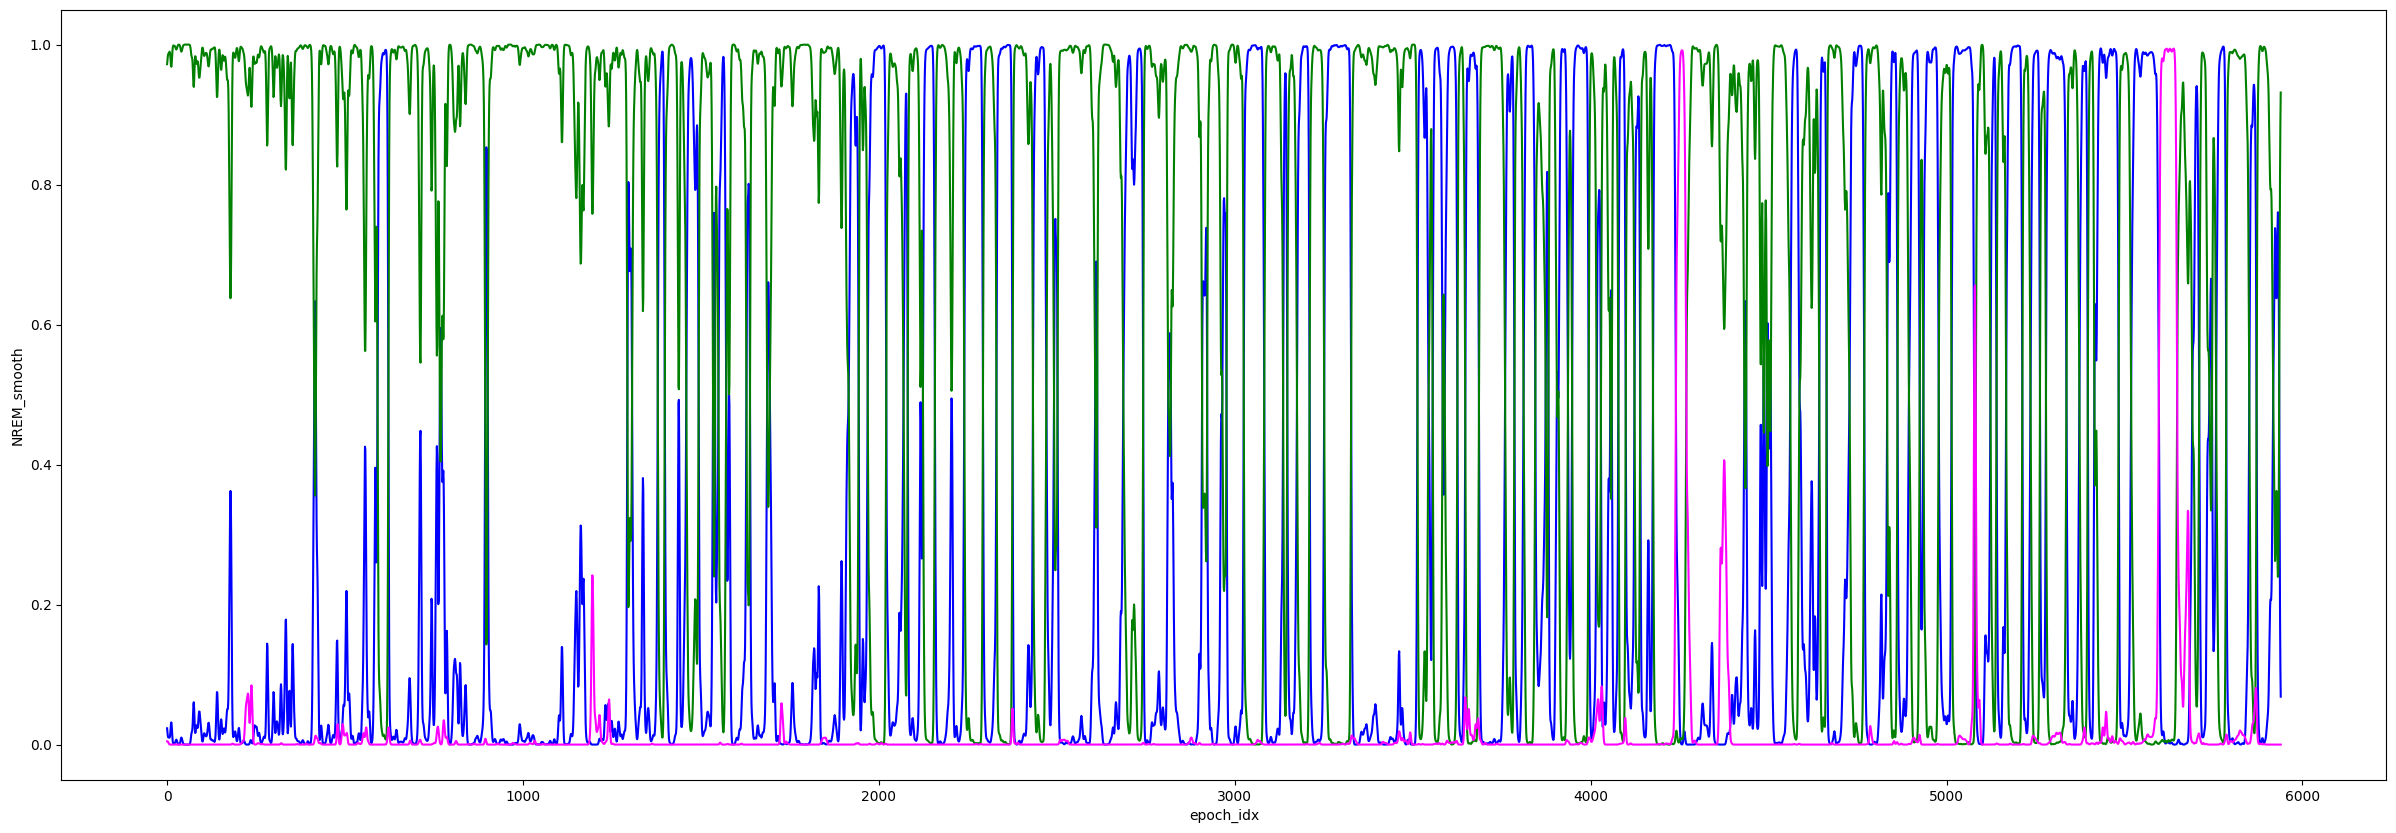

In [48]:
import seaborn as sns
f, ax = plt.subplots(1,1, figsize=(30,10))
sns.lineplot(x='epoch_idx', y='NREM_smooth', data=epoch_df, ax=ax, color='blue')
sns.lineplot(x='epoch_idx', y='Wake_smooth', data=epoch_df, ax=ax, color='green')
sns.lineplot(x='epoch_idx', y='REM_smooth', data=epoch_df, ax=ax, color='magenta')


In [55]:
thresh = 0.60
# Create a label column based solely on highest probability
epoch_df['label'] = epoch_df[['NREM_smooth', 'REM_smooth', 'Wake_smooth']].idxmax(axis=1).str.replace('_smooth', '')

# where none of the probabilities are above 0.85, set the label to "unclear"
epoch_df['label'] = epoch_df['label'].mask(epoch_df[['NREM_smooth', 'REM_smooth', 'Wake_smooth']].max(axis=1) < thresh, 'unclear')

In [56]:
epoch_df_clean = epy.hypno.utils.merge_consecutive_labels(epoch_df)
hypno_dir = f'{DEFS.anmat_root}/{subject}/{exp}/scoring_data/sync_block-{sync_block}/hypnograms/model_labelled'
wis.util.gen.check_dir(hypno_dir)
hypno_name = f'hypno_smooth_60cutoff.csv'
hypno_df = epoch_df_clean[['start_s', 'end_s', 'label']]
hypno_df.to_csv(f'{hypno_dir}/{hypno_name}', index=False)

In [35]:
bout_df_hypno = bout_df[['start_s', 'end_s', 'label']]
bout_name = f'pure_hsmm_bouts.csv'
hypno_dir = f'{DEFS.anmat_root}/{subject}/{exp}/scoring_data/sync_block-{sync_block}/hypnograms/model_labelled'
bout_df_hypno.to_csv(f'{hypno_dir}/{bout_name}', index=False)